In [8]:
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
import os
import pandas as pd
from collections import defaultdict

In [9]:
on_kaggle = False

on_kaggle = "KAGGLE_KERNEL_RUN_TYPE" in os.environ
    
if on_kaggle:
    load_data_prefix = "/kaggle/input/"
    save_data_prefix = "/kaggle/working/"
    model_prefix = "/kaggle/working/"
    
else:
    load_data_prefix = "./data/datasets/"
    save_data_prefix = "./data/"
    model_prefix = "./models/"
    

In [10]:
dataset_path = "4-million-sudoku-puzzles-easytohard/sudoku_cluewise"
save_filename = "sudoku_4m"

try:
    quizzes_4m = np.load(f"{save_data_prefix}{save_filename}.npz")["quizzes"]
    solutions_4m = np.load(f"{save_data_prefix}{save_filename}.npz")["solutions"]
    numbers_given_4m = np.load(f"{save_data_prefix}{save_filename}.npz")["numbers_given"]
except (FileNotFoundError, KeyError):
    quizzes_4m = np.zeros((4000000, 81), np.int32)
    solutions_4m = np.zeros((4000000, 81), np.int32)
    numbers_given_4m = np.zeros((4000000), np.int32)
    for i, line in enumerate(tqdm(open(f'{load_data_prefix}{dataset_path}.csv', 'r').read().splitlines()[1:])):
        quiz, solution, numbers_given = line.split(",")
        for j, q_s in enumerate(zip(quiz, solution)):
            q, s = q_s
            quizzes_4m[i, j] = q
            solutions_4m[i, j] = s
        numbers_given_4m[i] = numbers_given
    np.savez(f"{save_data_prefix}{save_filename}.npz", quizzes=quizzes_4m, solutions=solutions_4m, numbers_given=numbers_given_4m)

In [11]:
dataset_path = "sudoku/sudoku"
save_filename = "sudoku_1m"

try:
    quizzes_1m = np.load(f"{save_data_prefix}{save_filename}.npz")["quizzes"]
    solutions_1m = np.load(f"{save_data_prefix}{save_filename}.npz")["solutions"]
    numbers_given_1m = np.load(f"{save_data_prefix}{save_filename}.npz")["numbers_given"]
except (FileNotFoundError, KeyError):
    quizzes_1m = np.zeros((1000000, 81), np.int32)
    solutions_1m = np.zeros((1000000, 81), np.int32)
    numbers_given_1m = np.zeros((1000000), np.int32)
    for i, line in enumerate(tqdm(open(f'{load_data_prefix}{dataset_path}.csv', 'r').read().splitlines()[1:])):
        quiz, solution = line.split(",")
        for j, q_s in enumerate(zip(quiz, solution)):
            q, s = q_s
            quizzes_1m[i, j] = q
            solutions_1m[i, j] = s
    
        numbers_given_1m[i] = (quizzes_1m[i]!=0).sum()

    np.savez(f"{save_data_prefix}{save_filename}.npz", quizzes=quizzes_1m, solutions=solutions_1m, numbers_given=numbers_given_1m)

In [12]:
dataset_path = "3-million-sudoku-puzzles-with-ratings/sudoku-3m"
save_filename = "sudoku_3m"

try:
    quizzes_3m = np.load(f"{save_data_prefix}{save_filename}.npz")["quizzes"]
    solutions_3m = np.load(f"{save_data_prefix}{save_filename}.npz")["solutions"]
    numbers_given_3m = np.load(f"{save_data_prefix}{save_filename}.npz")["numbers_given"]
except (FileNotFoundError, KeyError):
    quizzes_3m = np.zeros((3000000, 81), np.int32)
    solutions_3m = np.zeros((3000000, 81), np.int32)
    numbers_given_3m = np.zeros((3000000), np.int32)
    for i, line in enumerate(tqdm(open(f'{load_data_prefix}{dataset_path}.csv', 'r').read().splitlines()[1:])):
        newline = line.replace(".", "0")
        _, quiz, solution, numbers_given, _ = newline.split(",")
        for j, q_s in enumerate(zip(quiz, solution)):
            q, s = q_s
            quizzes_3m[i, j] = q
            solutions_3m[i, j] = s

        numbers_given_3m[i] = numbers_given


    np.savez(f"{save_data_prefix}{save_filename}.npz", quizzes=quizzes_3m, solutions=solutions_3m, numbers_given=numbers_given_3m)

## Visualising dataset differences

In [13]:
df1m = pd.DataFrame({"numbers_given": numbers_given_1m})
df1m = df1m.groupby("numbers_given").size().reset_index(name="count")
df1m

df3m = pd.DataFrame({"numbers_given": numbers_given_3m})
df3m = df3m.groupby("numbers_given").size().reset_index(name="count")

df4m = pd.DataFrame({"numbers_given": numbers_given_4m})
df4m = df4m.groupby("numbers_given").size().reset_index(name="count")

all_puzzles = df1m.merge(df3m, on="numbers_given", how="outer", suffixes=["_1m", "_3m"]).merge(df4m, on="numbers_given", how="outer")
all_puzzles = all_puzzles.rename(columns={"count_1m": "1m dataset", "count_3m": "3m dataset", "count": "4m dataset", "numbers_given": "Numbers given"})
all_puzzles.set_index("Numbers given", inplace=True)

<Axes: xlabel='Numbers given', ylabel='Puzzle count'>

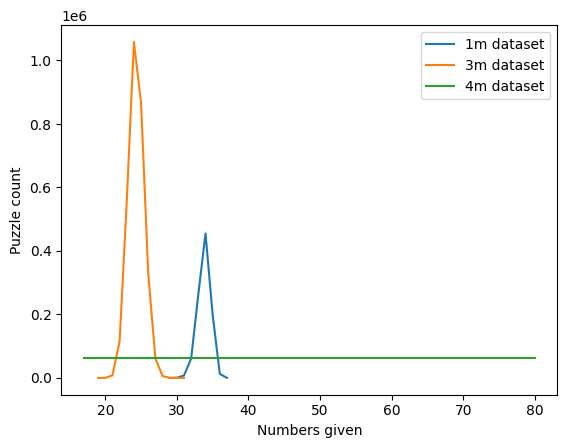

In [14]:
all_puzzles.plot(ylabel="Puzzle count")

In [15]:
quizzes = quizzes_4m
solutions = solutions_4m
numbers_given = numbers_given_4m

In [16]:
class CustomSudokuDataset(Dataset):
    def __init__(self, quizzes, solutions, numbers_given, transform=None, target_transform=None):
        self.quizzes = torch.from_numpy(quizzes).to(torch.int64)
        self.solutions = torch.from_numpy(solutions).to(torch.int64)
        self.numbers_given = torch.from_numpy(numbers_given).to(torch.int32)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.quizzes)

    def __getitem__(self, idx):
        quiz = self.quizzes[idx]
        solution = self.solutions[idx]
        nums_given = self.numbers_given[idx]
        if self.transform:
            quiz = self.transform(quiz)
        if self.target_transform:
            solution = self.target_transform(solution)
        return quiz.type(torch.float).cuda(), solution.type(torch.long).cuda(), nums_given.cuda()

In [17]:
def one_hot_options(input_tensor):
    return F.one_hot(input_tensor, 10)[:,1:]

In [18]:
dataset = CustomSudokuDataset(quizzes, solutions, numbers_given, one_hot_options)

In [19]:
generator = torch.Generator().manual_seed(42)
training_data, validation_data = random_split(dataset, [0.8, 0.2], generator=generator)

In [20]:
# we are also going to take a subset of the validation_data to run through a final check where we input the predictions one at a time
_, test_data = random_split(validation_data, [0.9, 0.1], generator=generator)

In [21]:
batch_size = 64

In [22]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None, mb=None, epoch_no=1, graphs=None):
    plot_x_batches = 200
    size = len(dataloader.dataset)
    losses = []
    item_count = []

    # used to calculate mean loss over. + 10 for first time as need to set initial loss high for LR scheduler
    batch_set_loss = torch.zeros(plot_x_batches, requires_grad=False) + 10
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y, _) in enumerate(progress_bar(dataloader, parent=mb)):
        mb.child.comment = "Training loop"
        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(X, y, preds)[0]

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            batch_set_loss[batch % plot_x_batches] = loss.item()

            if batch % plot_x_batches == 0 and batch != 0:
                loss, current = batch_set_loss.mean().item(), (batch + 1) * len(X)

                if scheduler is not None:
                    # update lr scheduler
                    scheduler.step(loss)
                
                # reset batch set loss
                batch_set_loss = torch.zeros(plot_x_batches, requires_grad=False)
                losses.append(loss)
                item_count.append(current)
                
                graphs[epoch_no - 1]=[item_count, losses]
                
                
                np_graphs = np.array(graphs[epoch_no - 1])[1]
                
                if epoch_no > 1:
                    prev_epoch_np_graphs = np.array(graphs[:epoch_no - 1])[:,1]
                    np_graphs = np.concatenate((np_graphs, prev_epoch_np_graphs.flatten()))
                    
                upper_bound = np_graphs.max()
                lower_bound = np_graphs.min()
                padding = 0.02
                
                mb.update_graph(graphs, [0, size], [lower_bound-padding, upper_bound+padding])


def test_loop(dataloader, model, loss_fn, mb=None, epoch_no=1):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y, _ in progress_bar(dataloader, parent=mb):
            if mb is not None:
                mb.child.comment = "Validation loop"
            preds = model(X)
            loss, correct = loss_fn(X, y, preds)
            total_loss += loss.item()
            total_correct += correct.item()

        total_loss /= num_batches
        total_correct /= size*81
        if mb is not None:
            mb.write(f"Epoch {epoch_no} Test Error: \n Accuracy: {(100*total_correct):>0.1f}%, Avg loss: {total_loss:>8f}")
        else:
            print(f"Epoch {epoch_no} Test Error: \n Accuracy: {(100*total_correct):>0.1f}%, Avg loss: {total_loss:>8f}")
    return total_loss

# Loss Functions

Expected to return a tuple in the format `(loss, num_correct)`

In [24]:
def loss_replace_known_values(X, y, preds):
    loss_fn = nn.CrossEntropyLoss()

    # replace known values with their correct alternatives
    mask = (X.max(2).values == 0).type(torch.int).unsqueeze(2)
    y2 = F.one_hot(y, 10)[:,:,1:]
    preds = ((y2 * (1-mask)) + preds*mask)
    
    # remove values already known 
    missing_idx = (mask[0].squeeze() == 1).nonzero(as_tuple=True)[0]
    preds = preds[:, (missing_idx), :]
    y = y[:, (missing_idx)]
    
    pred_split = preds.permute(0, 2, 1)
    # returns loss, # correct
    loss = loss_fn(pred_split, y-1)
    num_correct = (pred_split.argmax(1) == y-1).type(torch.int).sum()
    return loss, num_correct

In [25]:
def loss_compare_all_numbers(X, y, preds):
    loss_fn = nn.CrossEntropyLoss()

    # Cross Entropy Loss required the Batch Size, then classes (numbers 1-9 in our case), then the dimensions inputs for each batch (shape 81)
    pred_split = preds.permute(0, 2, 1)

    loss = loss_fn(pred_split, y-1)
    num_correct = (pred_split.argmax(1) == y-1).type(torch.int).sum()

    return loss, num_correct

In [26]:
def compare_tensors(tensor1, tensor2):
    result_tensor = torch.zeros_like(tensor1, dtype=torch.float32)
    result_tensor[tensor1 == tensor2] = 1
    return result_tensor

def loss_remove_wrong_answers(X, y, preds):
    loss_fn = nn.CrossEntropyLoss()

    # replace known values with their correct alternatives
    mask = (X.max(2).values == 0).type(torch.int).unsqueeze(2)
    y2 = F.one_hot(y, 10)[:,:,1:]
    preds = ((y2 * (1-mask)) + preds*mask)

    second_mask = compare_tensors(y2, preds)
    preds = preds * second_mask

    # remove values already known 
    missing_idx = (mask[0].squeeze() == 1).nonzero(as_tuple=True)[0]
    preds = preds[:, (missing_idx), :]
    y = y[:, (missing_idx)]

    pred_split = preds.permute(0, 2, 1)
    # returns loss, # correct
    loss = loss_fn(pred_split, y-1)
    num_correct = (pred_split.argmax(1) == y-1).type(torch.int).sum()
    return loss, num_correct

# Baseline scoring

We're going to create a model which just returns random numbers. This gives us an idea of what the baseline accuracy is. Anything above this level is the model starting to make _some_ correct predictions.

In [27]:
class base_model:
    def __call__(self, x):
        # generate random numbers for all of the cells
        rand_preds = (torch.rand_like(x)*8) + 1
        
        return rand_preds
    
    def eval(self):
        pass

In [28]:
# test_loop(validation_dataloader, base_model(), loss_compare_all_numbers)

In [29]:
# test_loop(validation_dataloader, base_model(), loss_replace_known_values)

We can see that this model has 48.2% accuracy when just returning the initial values. This means that any model which does about this well may simply be learning to return the input results. 

Our input is the numbers 1-9 (one-hot encoded) so if we wrote some code which simply returned the input values and also randomly guessed a number between these values, then we'd get `41.7 + (100-41.7)*0.111 = 48.17%` accuracy. This means for our model to be truly starting to correctly predict it must be above this baseline accuracy.

# Models

In [30]:
# count the number of trainable parameters for a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
class LinearNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [32]:
count_parameters(LinearNN())

156729

In [33]:
class LinearNNLarge(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [34]:
count_parameters(LinearNNLarge())

528729

In [35]:
class LinearNNXL(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 1530),
            nn.ReLU(),
            nn.Linear(1530, 1530),
            nn.ReLU(),
            nn.Linear(1530, 1530),
            nn.ReLU(),
            nn.Linear(1530, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

count_parameters(LinearNNXL())

6917859

In [36]:
class LinearNnXxl(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [37]:
class LinearNnXxl_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [38]:
class LinearNnXxl_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [39]:
class LinearNnXxl_v4(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (81, 9))
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(729, 3000),
            nn.ReLU(),
            nn.Linear(3000, 3000),
            nn.ReLU(),
            nn.Linear(3000, 3000),
            nn.ReLU(),
            nn.Linear(3000, 729),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.unflatten(logits)

In [40]:
count_parameters(LinearNnXxl_v4())

22383729

In [41]:
class CNNBase(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 729, kernel_size=3, stride=3), # 1x1
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [42]:
count_parameters(CNNBase())

538812

In [43]:
class CNNBaseXL(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(729, 850, kernel_size=3, stride=3), # 1x1
        )

        self.linear = nn.Sequential(
            nn.Linear(850, 850),
            nn.ReLU(),
            nn.Linear(850, 729),
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        cnn = self.linear_relu_stack(mod_x).flatten(1)
        logits = self.linear(cnn)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [44]:
count_parameters(CNNBaseXL())

6981207

In [45]:
class CNNStrideOne(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=1), # 7x7
            nn.ReLU(),
            nn.Conv2d(81, 81, kernel_size=3, stride=1), # 5x5
            nn.ReLU(),
            nn.Conv2d(81, 81, kernel_size=3, stride=1), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 729, kernel_size=3, stride=1), # 1x1
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [46]:
count_parameters(CNNStrideOne())

657072

In [47]:
class CNNLinear(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 81, kernel_size=3, stride=3), # 1x1
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(81, 729),
#             nn.ReLU(),
#             nn.Conv2d(81, 729, kernel_size=3),
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [48]:
class CNNCombi(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.Conv2d(81, 81, kernel_size=3, stride=3), # 1x1
            nn.ReLU(),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(1539, 1539),
            nn.ReLU(),
            nn.Linear(1539, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).squeeze(3)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1,2)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [49]:
count_parameters(CNNCombi())

3571776

## CNNCombiExtraConv - best architecture

In [50]:
class CNNCombiExtraConv(nn.Module):
    initial_conv_out = 81
    second_conv_out = 729
    linear_in = 2187
    linear_hidden = 2187
    
    def __init__(self):
        super().__init__()
        
        self.three_by_three_9 = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
        )

        self.three_by_three_81 = nn.Sequential(
            nn.Conv2d(self.initial_conv_out, self.second_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(self.linear_in, self.linear_hidden),
            nn.ReLU(),
            nn.Linear(self.linear_hidden, 729),
        )
        
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))

        # conv 1
        conv1 = self.three_by_three_9(mod_x)
        conv1 = self.three_by_three_81(conv1).squeeze(2)

        #conv 2
        conv2 = self.one_by_nine(mod_x).squeeze().unflatten(2, (3,3))
        conv2 = self.three_by_three_81(conv2).squeeze(2)

        # conv 3
        conv3 = self.nine_by_one(mod_x).squeeze().unflatten(2, (3,3))
        conv3 = self.three_by_three_81(conv3).squeeze(2)

        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1,2)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits
    
count_parameters(CNNCombiExtraConv())

6932304

In [51]:
class CNNCombiExtraConvXl(nn.Module):
    initial_conv_out = 243
    second_conv_out = 2187
    linear_in = 6561
    linear_hidden = 1000
    
    def __init__(self):
        super().__init__()
        
        self.three_by_three_9 = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
        )

        self.three_by_three_81 = nn.Sequential(
            nn.Conv2d(self.initial_conv_out, self.second_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(self.linear_in, self.linear_hidden),
            nn.ReLU(),
            nn.Linear(self.linear_hidden, 729),
        )
        
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))

        # conv 1
        conv1 = self.three_by_three_9(mod_x)
        conv1 = self.three_by_three_81(conv1).squeeze(2)

        #conv 2
        conv2 = self.one_by_nine(mod_x).squeeze().unflatten(2, (3,3))
        conv2 = self.three_by_three_81(conv2).squeeze(2)

        # conv 3
        conv3 = self.nine_by_one(mod_x).squeeze().unflatten(2, (3,3))
        conv3 = self.three_by_three_81(conv3).squeeze(2)

        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1,2)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

count_parameters(CNNCombiExtraConvXl())

12136663

In [52]:
class CNNCombiExtraConvXlNorm(nn.Module):
    initial_conv_out = 243
    second_conv_out = 2187
    linear_in = 6561
    linear_hidden = 1000
    
    def __init__(self):
        super().__init__()
        
        self.three_by_three_9 = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(self.initial_conv_out),
        )

        self.three_by_three_81 = nn.Sequential(
            nn.Conv2d(self.initial_conv_out, self.second_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(self.second_conv_out),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(self.initial_conv_out),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(self.initial_conv_out),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(self.linear_in, self.linear_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(self.linear_hidden),
            nn.Linear(self.linear_hidden, 729),
        )
        
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))

        # conv 1
        conv1 = self.three_by_three_9(mod_x)
        conv1 = self.three_by_three_81(conv1).squeeze(2)

        #conv 2
        conv2 = self.one_by_nine(mod_x).squeeze().unflatten(2, (3,3))
        conv2 = self.three_by_three_81(conv2).squeeze(2)

        # conv 3
        conv3 = self.nine_by_one(mod_x).squeeze().unflatten(2, (3,3))
        conv3 = self.three_by_three_81(conv3).squeeze(2)

        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1,2)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

count_parameters(CNNCombiExtraConvXl())

12136663

In [53]:
class CNNCombiExtraConvMoreLinear(nn.Module):
    initial_conv_out = 81
    second_conv_out = 729
    linear_in = 2187
    linear_hidden = 1800
    
    def __init__(self):
        super().__init__()
        
        self.three_by_three_9 = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
        )

        self.three_by_three_81 = nn.Sequential(
            nn.Conv2d(self.initial_conv_out, self.second_conv_out, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, self.initial_conv_out, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(self.linear_in, self.linear_hidden),
            nn.ReLU(),
            nn.Linear(self.linear_hidden, self.linear_hidden),
            nn.ReLU(),
            nn.Linear(self.linear_hidden, self.linear_hidden),
            nn.ReLU(),
            nn.Linear(self.linear_hidden, 729),
        )
        
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))

        # conv 1
        conv1 = self.three_by_three_9(mod_x)
        conv1 = self.three_by_three_81(conv1).squeeze(2)

        #conv 2
        conv2 = self.one_by_nine(mod_x).squeeze().unflatten(2, (3,3))
        conv2 = self.three_by_three_81(conv2).squeeze(2)

        # conv 3
        conv3 = self.nine_by_one(mod_x).squeeze().unflatten(2, (3,3))
        conv3 = self.three_by_three_81(conv3).squeeze(2)

        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1,2)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits
    
count_parameters(CNNCombiExtraConvMoreLinear())

12287025

## Normalisation

In [54]:
class CNNBaseNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(9, 81, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(81),
            nn.Conv2d(81, 729, kernel_size=3, stride=3), # 1x1
        )

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        logits = self.linear_relu_stack(mod_x)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [55]:
class CNNCombiNormXL_v1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(19683, 2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Linear(2000, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).flatten(2)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [56]:
count_parameters(CNNCombiNormXL_v1())

41014437

In [57]:
class CNNCombiNormXL(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 729, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(729),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(19683, 10000),
            nn.ReLU(),
            nn.BatchNorm1d(10000),
            nn.Linear(10000, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).flatten(2)
        conv2 = self.one_by_nine(mod_x).squeeze()
        conv3 = self.nine_by_one(mod_x).squeeze()
        conv_concat = torch.cat((conv1, conv2, conv3), dim=2)
        conv_concat = conv_concat.flatten(1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

In [58]:
class CNNCombiNormSmall(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.three_by_three = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=3, stride=3), # 3x3
            nn.ReLU(),
            nn.BatchNorm2d(9),
        )
        
        self.one_by_nine = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=(1,9), stride=1), # 9x1
            nn.ReLU(),
            nn.BatchNorm2d(9),
        )
        
        self.nine_by_one = nn.Sequential(
            nn.Conv2d(9, 9, kernel_size=(9,1), stride=1), # 1x9
            nn.ReLU(),
            nn.BatchNorm2d(9),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(243, 729),
        )
        

    def forward(self, x):
        mod_x = x.permute([0,2,1])
        mod_x = mod_x.unflatten(2,(9,9))
        conv1 = self.three_by_three(mod_x).squeeze().flatten(1)
        conv2 = self.one_by_nine(mod_x).squeeze().flatten(1)
        conv3 = self.nine_by_one(mod_x).squeeze().flatten(1)
        conv_concat = torch.cat((conv1, conv2, conv3), dim=1)
        logits = self.linear(conv_concat)
        logits = logits.squeeze().unflatten(1, (81,9))
        return logits

# Learning Rates

In [59]:
def lr_finder(training_data, model_class, loss_fn, initial_lr=1e-4, saved_weights_path=None, optimizer_class=torch.optim.AdamW):
    dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
    min_loss = 1000
    learning_rate = initial_lr
    lrs = []
    losses = []
    local_min = 1000
    
    model = model_class().to("cuda")
    if saved_weights_path:
        model.load_state_dict(torch.load(saved_weights_path))

    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    mb = master_bar(range(1))

    for _ in mb:

        for batch, (X, y, _) in enumerate(progress_bar(dataloader, parent=mb)):
            # Compute prediction and loss
            preds = model(X)
            optimizer = optimizer_class(model.parameters(), lr=learning_rate)

            loss = loss_fn(X, y, preds)[0]
                
            if loss < local_min:
                local_min = loss.item()
            if loss < min_loss:
                min_loss = loss
            elif loss > min_loss * 3:
                break

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if batch % 200 == 0:
                losses.append(local_min)
                lrs.append(learning_rate)

                graphs=[[lrs, losses]]
                np_graphs = np.array(graphs[0])
                    
                x_upper_bound, x_lower_bound = np_graphs[0].max(), np_graphs[0].min()
                y_upper_bound, y_lower_bound = np_graphs[1].max(), np_graphs[1].min()
                padding = 0.02
                
                plt.xscale('log')
                mb.update_graph(graphs, [x_lower_bound, x_upper_bound], [y_lower_bound-padding, y_upper_bound+padding])
                mb.graph_ax.set_xscale('log')

                # set values for next loop
                learning_rate*=1.3
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
                local_min = 1000
    plt.xscale('log')
    plt.plot(lrs, losses)
        
        

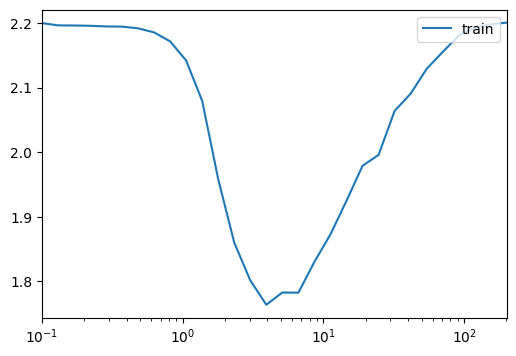

/home/jonny/projects/sudoku_solver/.venv/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


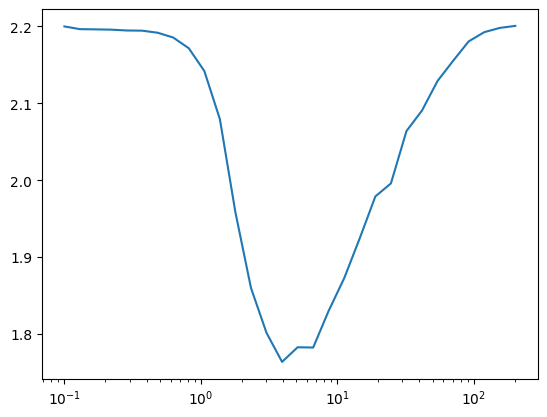

In [61]:
lr_finder(training_data, LinearNN, loss_compare_all_numbers, initial_lr=1e-1, optimizer_class=torch.optim.SGD)

In [133]:
# lr_finder(training_data, CNNCombiExtraConvXl, loss_compare_all_numbers, initial_lr=1e-6, optimizer_class=torch.optim.AdamW)

In [86]:
def parameters_comparison(epoch_labels: list[str], model_class_provider, learning_rates_provider, loss_function_provider=None, optimiser_provider=None, scheduler_provider=None, training_data=training_data, dataloader_provider=None):
    """
    This function is designed to compare parameters and their effect on model training. 
    A number of providers can be passed in which can either change on each run or return the same value each time.

    epoch_labels: the labels that should appear on the graph for each epoch
    model_class_provider: callable which provides the model to use in the next epoch
    learning_rates_provider: callable which provides the learning rate to use within the next epoch
    loss_function_provider: callable which provides the loss function to use, defaults to `loss_compare_all_numbers`
    optimiser_provider: callable which takes in the parameters and learning rate, and provides the optimiser to use, defaults to AdamW
    scheduler_provider: callable which takes in the optimiser provides the scheduler to use, defaults to no scheduler
    dataloader_provider: callable which takes in a dataset and provides the dataloader to use for each epoch. Typical use would be to compare shuffle true and false
    """
    val_count = len(epoch_labels)
    graphs = [[] for _ in range(val_count)]
    models = []
    
    mb = master_bar(range(1, val_count+1))
    mb.names = epoch_labels
    mb.main_bar.comment = "Parameters"

    # set seed so that all iterations use the same base point
    torch.manual_seed(42)

    results = []

    for t in mb:
        # dataloader
        if dataloader_provider:
            dataloader = dataloader_provider(training_data)
        else:
            dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)


        # learning rate
        learning_rate = learning_rates_provider()

        # model
        model_class = model_class_provider()
        model = model_class().cuda()
        model.train()
        models.append(model)

        # loss function
        if loss_function_provider is not None:
            loss_function = loss_function_provider()
        else:
            loss_function = loss_compare_all_numbers

        # optimiser
        if optimiser_provider is not None:
            optimizer = optimiser_provider(model.parameters(), lr=learning_rate)
        else:
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

        #scheduler
        if scheduler_provider is not None:
            scheduler = scheduler_provider(optimizer)
        else: 
            scheduler = None

        results.append(train_loop(dataloader, model, loss_function, optimizer, scheduler, mb, t, graphs))
        test_loop(validation_dataloader, model, loss_function, mb, t)
    
    return graphs, models

# Training

In [135]:
def train_model(model, epochs=5, learning_rate=0.01, loss_function=loss_replace_known_values, shuffle_after_first_epoch=False, training_data=training_data, optimizer_class=torch.optim.AdamW, use_scheduler=True):
    graphs = [[] for _ in range(epochs)]
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=not shuffle_after_first_epoch)

    mb = master_bar(range(1, epochs+1))
    mb.names = [f"Epoch {i+1}" for i in range(epochs)]
    mb.main_bar.comment = "Epochs"

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, patience=15, factor=0.5) if use_scheduler else None

    for t in mb:
        if shuffle_after_first_epoch and t == 2:
            train_dataloader =  DataLoader(training_data, batch_size=batch_size, shuffle=True)
        train_loop(train_dataloader, model, loss_function, optimizer, scheduler, mb, t, graphs)
        test_loop(validation_dataloader, model, loss_function, mb, t)
    
    return graphs

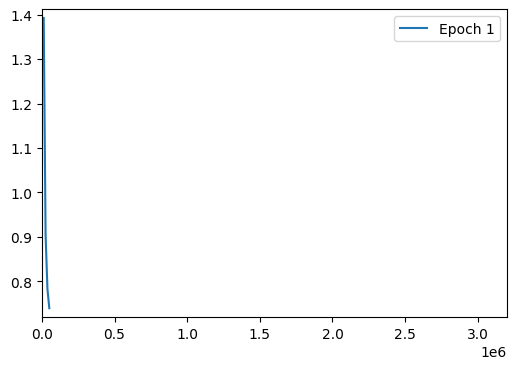

KeyboardInterrupt: 

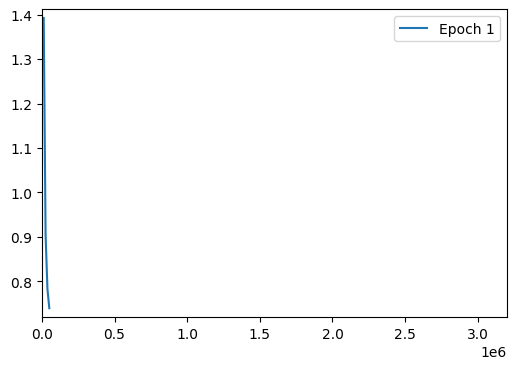

In [136]:
# model = CNNCombiExtraConvXlNorm().to("cuda")
# # model.load_state_dict(torch.load(f"{model_prefix}LinearNnXxl_v4_4mil.model"))
# results = train_model(model, learning_rate=4e-4, epochs=5, loss_function=loss_compare_all_numbers, shuffle_after_first_epoch=False, optimizer_class=torch.optim.AdamW, use_scheduler=True)

In [ ]:
# torch.save(model.state_dict(), f"{model_prefix}{model.__class__.__name__}_3m.model")

# Testing

In [ ]:
def has_duplicates_in_rows(tensor):
    for row in tensor:
         if row.bincount()[1:].max() > 1:
             return True
    return False

def check_valid_2(sol):
    sol = sol.reshape(9,9)
    # rows
    if has_duplicates_in_rows(sol):
        return False
    
    # cols
    cols = sol.permute(1,0)
    if has_duplicates_in_rows(cols):
        return False
    
    grids = sol.unfold(0,3,3).flatten(0).split(9)
    if has_duplicates_in_rows(grids):
        return False

    return True

def answer_loop(model, mb=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    dataloader = DataLoader(test_data, batch_size=512, shuffle=False)
    size = len(dataloader.dataset)
    total_numbers_correct, total_puzzles_correct, immediate_puzzles_correct = 0, 0, 0
    puzzle_difficulty_total_count = defaultdict(int)
    puzzle_difficulty_correct_count = defaultdict(int)


    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y, n in progress_bar(dataloader, parent=mb):
            immediate_solution = model(X)

            if mb is not None:
                mb.child.comment = "Final test loop"
            
            # remove predictions for values already known
            mask = (X.max(2).values == 0).type(torch.int).unsqueeze(2)
            X_update = X.clone()

            while mask.sum() > 0:
                preds = model(X_update)
                
                mask = (X_update.max(2).values == 0).type(torch.float).unsqueeze(2)
                
                preds_updated = preds + (torch.nan_to_num((mask-1)*float("Inf")))

                # get indicies of values that the model is most certain about for each batch
                # this is the idx of batches which still have values to fill out
                idx = mask.nonzero(as_tuple=True)[0].unique()
                certain_idx = preds_updated.flatten(1).argmax(1) # shape = [64]
                certain_cells = certain_idx // 9

                certain_numbers = preds_updated[idx, certain_cells[idx]].argmax(1) + 1
                certain_numbers_one_hot = F.one_hot(certain_numbers, 10)[:,1:]
                
                # replace the most certiain numbers in X
                X_update[idx, certain_cells[idx]] = certain_numbers_one_hot.type(torch.float)
            
            correct = loss_compare_all_numbers(X, y, X_update)[1]
            total_numbers_correct += correct.item()
            for i, puzzle_output in enumerate(X_update):
                puzzle_numbers_given = n[i]
                puzzle_difficulty_total_count[puzzle_numbers_given] += 1
                solution = puzzle_output.argmax(1) + 1
                if check_valid_2(solution):
                    total_puzzles_correct += 1
                    puzzle_difficulty_correct_count[puzzle_numbers_given] += 1


            for puzzle_output in immediate_solution:
                solution = puzzle_output.argmax(1) + 1
                if check_valid_2(solution):
                    immediate_puzzles_correct += 1
                    
        total_puzzles_correct /= size
        immediate_puzzles_correct /= size
        total_numbers_correct /= size*81

        output = f"Final Test: \n Numbers Correct: {(100*total_numbers_correct):>0.1f}%, Puzzles Correct: {(100*total_puzzles_correct):>0.1f}%, Puzzles Correct when immediately guessing: {(100*immediate_puzzles_correct):>0.1f}%"
        if mb is not None:
            mb.write(output)
        else:
            print(output)


        return puzzle_difficulty_total_count, puzzle_difficulty_correct_count

        

In [137]:
model = CNNCombiExtraConvXl().to("cuda")
model.load_state_dict(torch.load(f"{model_prefix}CNNCombiExtraConvXl.model"))

<All keys matched successfully>

In [139]:
total_count, correct_count = answer_loop(model)

Final Test: 
 Numbers Correct: 85.5%, Puzzles Correct: 48.2%, Puzzles Correct when immediately guessing: 33.9%


# Comparing parameters

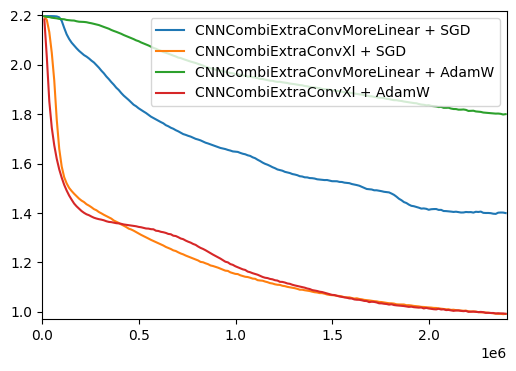

In [74]:
# test different base model architectures
model_iter = iter([CNNCombiExtraConvMoreLinear, CNNCombiExtraConvXl, CNNCombiExtraConvMoreLinear, CNNCombiExtraConvXl])
lr_iter = iter([10, 5, 4e-4, 3e-4])
optimiser_iter = iter([
    (lambda params, lr: torch.optim.SGD(params, lr, weight_decay=1e-5)),
    (lambda params, lr: torch.optim.SGD(params, lr, weight_decay=1e-5)),
    (lambda params, lr: torch.optim.AdamW(params, lr, weight_decay=1e-5)),
    (lambda params, lr: torch.optim.AdamW(params, lr, weight_decay=1e-5)),
])
labels = ["CNNCombiExtraConvMoreLinear + SGD", "CNNCombiExtraConvXl + SGD", "CNNCombiExtraConvMoreLinear + AdamW", "CNNCombiExtraConvXl + AdamW"]

results, models = parameters_comparison(
    epoch_labels=labels,
    model_class_provider=(lambda: next(model_iter)),
    learning_rates_provider=(lambda: next(lr_iter)),
    optimiser_provider=(lambda params, lr: next(optimiser_iter)(params, lr)),
    scheduler_provider=(lambda optimiser: torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, patience=10, verbose=True)),
)

for model, desc in zip(models, labels):
    torch.save(model.state_dict(), f"{model_prefix}{model.__class__.__name__}_param_compare_{desc}.model")

In [91]:
# test different base model architectures
labels = ["MLP - easy to hard", "MLP - shuffle"]
dataloader_iter = iter([
    (lambda data: DataLoader(data, batch_size=batch_size, shuffle=False)),
    (lambda data: DataLoader(data, batch_size=batch_size, shuffle=True)),
])

results, models = parameters_comparison(
    epoch_labels=labels,
    model_class_provider=(lambda: LinearNN),
    learning_rates_provider=(lambda: 3),
    optimiser_provider=(lambda params, lr: torch.optim.SGD(params, lr)),
    dataloader_provider=(lambda data: next(dataloader_iter)(data)),
)

for model, desc in zip(models, labels):
    torch.save(model.state_dict(), f"{model_prefix}{model.__class__.__name__}_param_compare_{desc}.model")

KeyboardInterrupt: 

In [69]:
results_unshuffled = results

In [64]:
results_shuffled

In [70]:
total_results = results.copy()

In [71]:
total_results = [results_unshuffled[0], results_shuffled[0]]

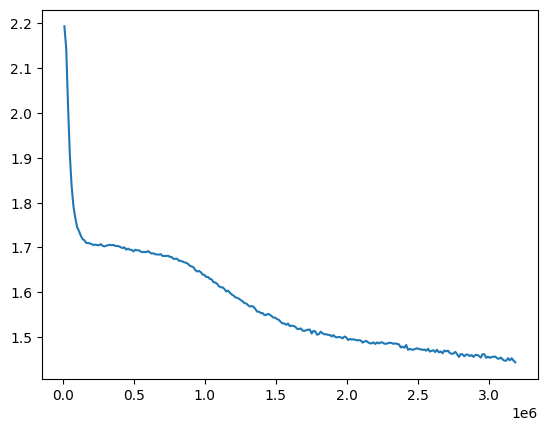

In [76]:

fig, ax = plt.subplots()
ax.plot(results_unshuffled[0][0], results_unshuffled[0][1])
#ax.plot(results_shuffled[0][0], results_shuffled[0][1])